In [1]:
import pandas as pd
import numpy as np

## Import dataset

In [2]:
data = pd.read_csv("dataset/MBA.csv")

In [3]:
data.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


## EDA

In [4]:
len(data)

6194

In [5]:
data.isnull().sum()

application_id       0
gender               0
international        0
gpa                  0
major                0
race              1842
gmat                 0
work_exp             0
work_industry        0
admission         5194
dtype: int64

In [6]:
numerical = ["gpa", "gmat", "work_exp"]
categorical = ["gender", "international", "major", "race", "work_industry", "admission"]

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

### Explore numerical values

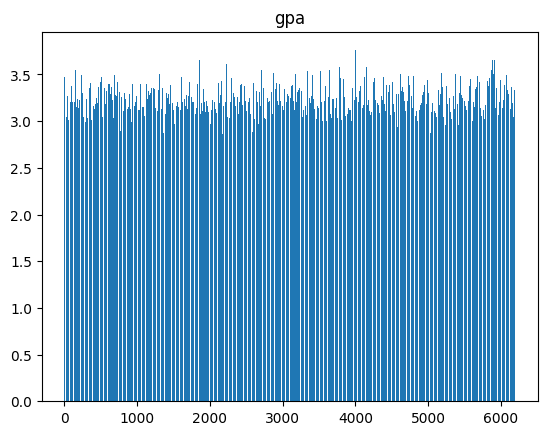

max value: 3.77
min value: 2.65
mean: 3.2507135938004517
median: 3.25


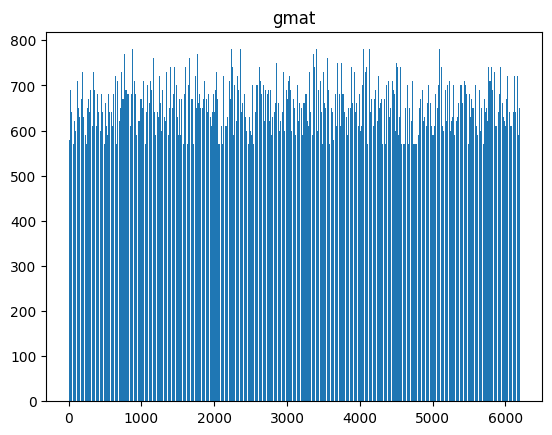

max value: 780.0
min value: 570.0
mean: 651.0929932192445
median: 650.0


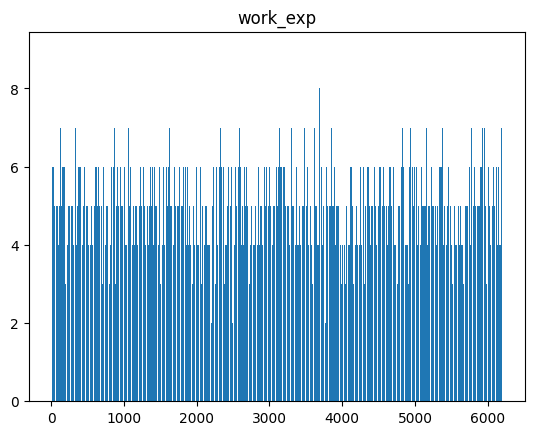

max value: 9.0
min value: 1.0
mean: 5.0169518889247655
median: 5.0


In [15]:
for category in numerical:
    plt.bar(data.application_id, data[category])
    plt.title(category)
    plt.show()
    print(f"max value: {np.max(data[category])}")
    print(f"min value: {np.min(data[category])}")
    print(f"mean: {data[category].mean()}")
    print(f"median: {data[category].median()}")

Text(0.5, 1.0, 'GPA distribution')

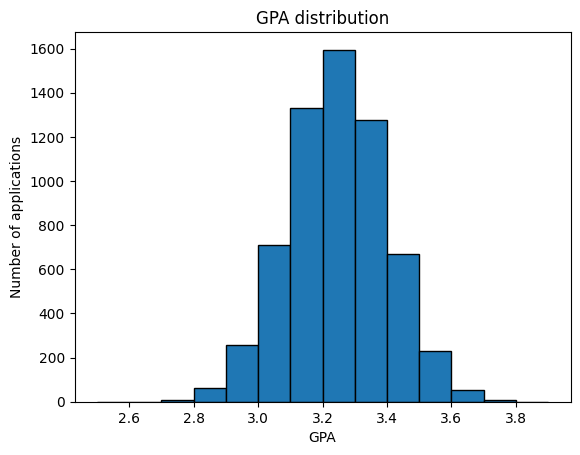

In [9]:
bins = np.arange(2.5, 4, 0.10)
plt.hist(data.gpa, bins=bins, edgecolor='black')
plt.xlabel('GPA')
plt.ylabel('Number of applications')
plt.title("GPA distribution")

(array([ 634., 1393., 1795., 1462.,  676.,  234.]),
 array([550., 590., 630., 670., 710., 750., 790.]),
 <BarContainer object of 6 artists>)

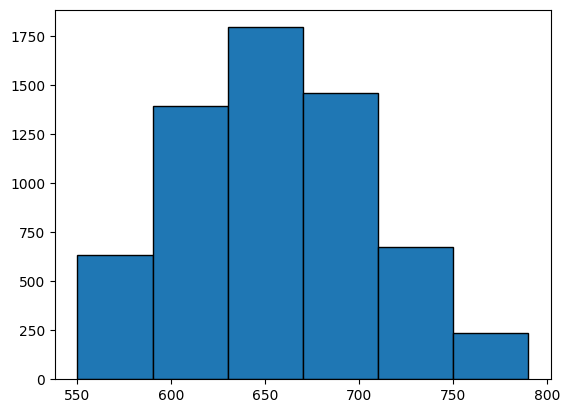

In [10]:
bins = np.arange(550, 800, 40)
plt.hist(data.gmat, bins=bins, edgecolor='black')

Text(0.5, 1.0, 'Work experience distribution')

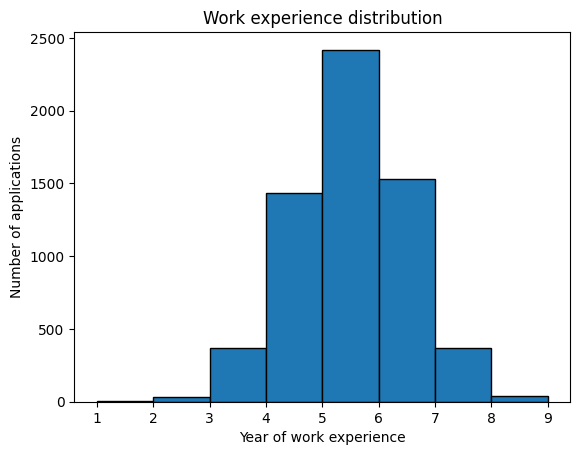

In [11]:
bins = np.arange(1, 10, 1)
plt.hist(data.work_exp, bins=bins, edgecolor='black')
plt.xlabel('Year of work experience')
plt.ylabel('Number of applications')
plt.title("Work experience distribution")

In [12]:
data[categorical].nunique()

gender            2
international     2
major             3
race              5
work_industry    14
admission         2
dtype: int64

### Explore categorical values

In [13]:
from collections import Counter

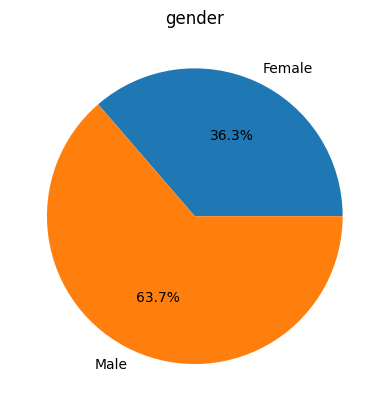

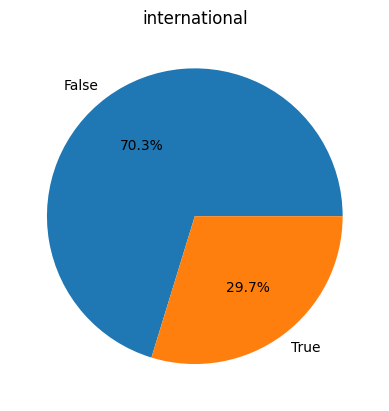

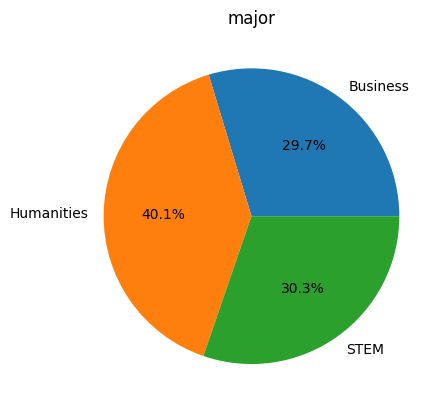

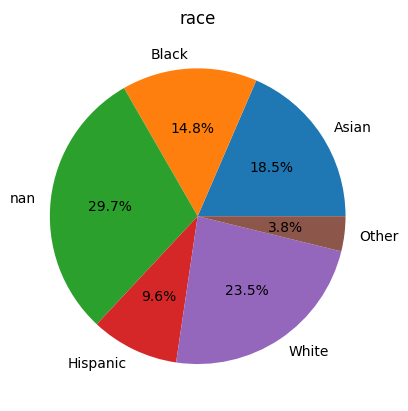

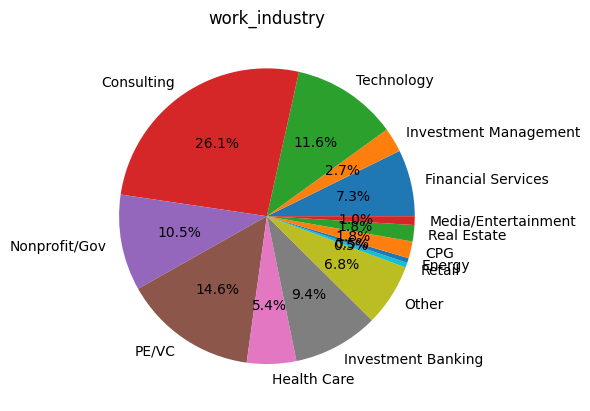

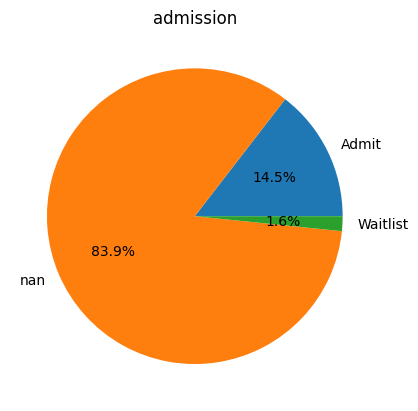

In [14]:
for category in categorical:
    counts_column = Counter(data[category])
    labels = list(counts_column.keys())
    values = list(counts_column.values())
    plt.pie(values, labels=labels, autopct='%1.1f%%')
    plt.title(category)
    plt.show()

### Prepare admission column

for training and evaluational purposes "Waitlist" in the admission column will be replaced by "Admit"

In [28]:
data['race'].fillna(value='Unknown', inplace=True)

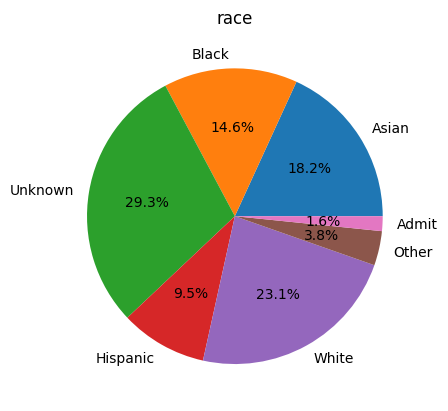

In [29]:
counts_column = Counter(data["race"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("race")
plt.show()

In [30]:
data[data["admission"] == "Waitlist"]["admission"] = "Admit"

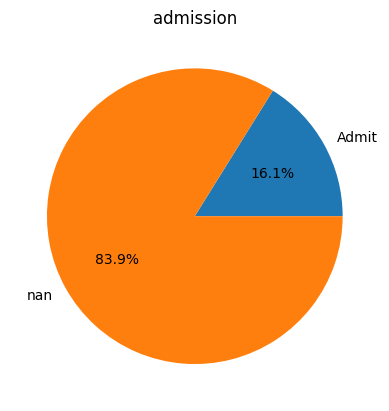

In [31]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

In [32]:
data["admission"] = (data["admission"] == "Admit").astype(int)

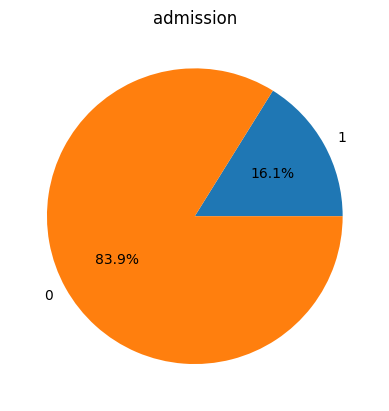

In [33]:
counts_column = Counter(data["admission"])
labels = list(counts_column.keys())
values = list(counts_column.values())
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("admission")
plt.show()

## Feature importance

In [42]:
categorical = ["gender", "international", "major", "race", "work_industry"]

In [43]:
from IPython.display import display

In [44]:
overall_admision = data.admission.mean()
overall_admision

np.float64(0.16144656118824668)

In [52]:
for category in categorical:
    print(category)
    data_category = data.groupby(category).admission.agg(mean='mean', count='count')
    data_category['difference'] = data_category['mean'] - overall_admision
    data_category['risk_ratio'] = data_category['mean'] / overall_admision
    display(data_category)
    print()

gender


,mean,count,difference,risk_ratio
gender,,,,
Admit,1.000000,100,0.838553,6.194000
Female,0.204453,2201,0.043006,1.266379
Male,0.115592,3893,-0.045854,0.715977



international


,mean,count,difference,risk_ratio
international,,,,
False,0.145259,4282,-0.016187,0.899736
True,0.153422,1812,-0.008025,0.950294
Admit,1.000000,100,0.838553,6.194000



major


,mean,count,difference,risk_ratio
major,,,,
Admit,1.000000,100,0.838553,6.194000
Business,0.148678,1816,-0.012768,0.920914
Humanities,0.150410,2440,-0.011037,0.931639
STEM,0.143090,1838,-0.018356,0.886301



race


,mean,count,difference,risk_ratio
race,,,,
Admit,1.000000,100,0.838553,6.194000
Asian,0.168889,1125,0.007442,1.046098
Black,0.088300,906,-0.073146,0.546932
Hispanic,0.105442,588,-0.056004,0.653109
Other,0.197425,233,0.035978,1.222850
Unknown,0.153422,1812,-0.008025,0.950294
White,0.170629,1430,0.009183,1.056878



work_industry


,mean,count,difference,risk_ratio
work_industry,,,,
Admit,1.000000,100,0.838553,6.194000
CPG,0.176991,113,0.015545,1.096283
Consulting,0.141236,1586,-0.020211,0.874815
Energy,0.093750,32,-0.067697,0.580688
Financial Services,0.194570,442,0.033124,1.205167
Health Care,0.122699,326,-0.038747,0.760000
Investment Banking,0.143357,572,-0.018090,0.887951
Investment Management,0.218182,165,0.056735,1.351418
Media/Entertainment,0.122807,57,-0.038640,0.760667


## Split data

In [23]:
from sklearn.model_selection import train_test_split

In [37]:
data_full_train, data_test = train_test_split(data, test_size=0.2)
data_train, data_val = train_test_split(data_full_train, test_size=0.25)

In [38]:
print(f"train: {len(data_train)}, val: {len(data_val)}, test: {len(data_test)}")

train: 3716, val: 1239, test: 1239


In [39]:
data_train = data_train.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)

In [40]:
y_train = data_train.admission.values
y_val = data_val.admission.values
y_test = data_test.admission.values

In [41]:
del data_train["admission"]
del data_val["admission"]
del data_test["admission"]